# Insurance Complaint Analysis using Machine Learning

As a baseline, Logistic Regression & Random Forest Classifiers can be used to make classifications about disposition in the insurance complaints dataset. These models are very simple, yet interpretable, and allow a solid starting point to assess several things about the dataset and models. First, it assesses what data preprocesses techniques are needed to improve model performance, and second, it assesses whether the data would benefit from a more complex model, such as a Neural Network or Boosting model.

### Load Data and Import Packages

In [31]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns

insurance_data = pd.read_csv("Insurance_Data.csv", delimiter=",", quotechar='"')
print(insurance_data.shape)

insurance_data = insurance_data.dropna(subset=['Disposition'])
print(insurance_data.shape)

(38267, 12)
(22979, 12)


### Feature Engineering

To make a much more useful feature, the feature 'Duration' is extracted from the features 'Closed' (the date the claim was closed) minus 'Opened' (the date the claim was opened). This allows the model to extract meaningful insights from the duration the claim was opened for.

In [22]:
insurance_data['Opened'] = pd.to_datetime(insurance_data['Opened'], format='%m/%d/%Y')
insurance_data['Closed'] = pd.to_datetime(insurance_data['Closed'], format='%m/%d/%Y')

insurance_data['Duration'] = (insurance_data['Closed'] - insurance_data['Opened']).dt.days

insurance_data.drop(['Opened', 'Closed'], axis=1, inplace=True)

print(insurance_data['Duration'])

0         2.0
1        94.0
2        30.0
3        94.0
4        22.0
         ... 
38261    13.0
38262    57.0
38263    62.0
38264    22.0
38265    17.0
Name: Duration, Length: 22979, dtype: float64


### Data Preprocessing

Further data preprocessing was necessary to deal with issues with the dataset. The following data preprocessing techniques were applied to handle these issues:

1. Dropped rows with missing target
2. Features with NaN data were imputed
3. Classes with fewer than 10 samples were filtered out
4. Numeric features were normalized, and Categorical features were one-hot encoded

These techniques effectively cleaned the dataset to allow the models to make more accurate predictions.

In [23]:
# Drop rows with missing target
target_column = 'Disposition'
insurance_data = insurance_data[insurance_data[target_column].notna()]
y = insurance_data[target_column]

# Define features
categorical_features = ['Coverage', 'SubCoverage', 'Reason', 'SubReason']
numeric_features = ['Duration', 'Recovery']

# Convert numeric column safely
insurance_data['Recovery'] = pd.to_numeric(insurance_data['Recovery'], errors='coerce')

# Select feature columns
X = insurance_data[categorical_features + numeric_features]

# Filter out underrepresented classes
threshold = 10
value_counts = y.value_counts()
valid_classes = value_counts[value_counts >= threshold].index
mask = y.isin(valid_classes)
X = X[mask]
y = y[mask]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### Training Linear Regression and Random Forest Classifiers

In [24]:
# Final pipeline using Logistic Regression
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Final pipeline using Random Forest Classifier
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit and evaluate
lr_clf.fit(X_train, y_train)
lr_y_pred = lr_clf.predict(X_test)
print("Classification using Logistic Regression:")
print(classification_report(y_test, lr_y_pred))

rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)
print("\nClassification using Random Forest:")
print(classification_report(y_test, rf_y_pred))

Classification using Logistic Regression:
                                                 precision    recall  f1-score   support

                                 Claim Reopened       0.02      0.86      0.04         7
                                  Claim Settled       0.71      0.38      0.49       984
                    Company Position Overturned       0.29      0.49      0.36       230
                 Company Position Substantiated       0.76      0.24      0.37      2032
                            Complaint Withdrawn       0.02      0.30      0.03        23
              Compromised Settlement/Resolution       0.32      0.42      0.36       251
                       Insufficient Information       0.07      0.33      0.12        58
                   No Action Requested/Required       0.35      0.54      0.43       313
                                No Jurisdiction       0.26      0.63      0.37       220
Question of Fact/Contract/Provision/Legal Issue       0.32      0.3

#### The results show the following:

#### Logistic Regression:
- Accuracy: 34%
This metric suggests the model is not performing very well. This is expected, as a logistic regression model is much too simple to capture the fine details and correlations in the data.
- Low precision across smaller categories, but high recall (low F-1 score)
This shows that the model rarely makes correct predictions for classes with fewer samples, and the high recall indicates there are many false positives in the classifications. This is reflected in the low F-1 score for these classes.

This shows that the logistic regression model is not an effective model for classifying the data, and also indicates the data is severely imbalanced, with most samples falling into a select few categories.

#### Random Forest:
- Accuracy: 60%
This metric shows a significant improvement over the Logistic Regression model, which indicates that the data benefits from a higher degree of model complexity.
- Low F-1 Scores for smaller categories
This enforces the proof that the dataset is extremely imbalanced, with most samples falling into the same few categories, and smaller categories being underrepresented in the model.

### Confusion Matrices

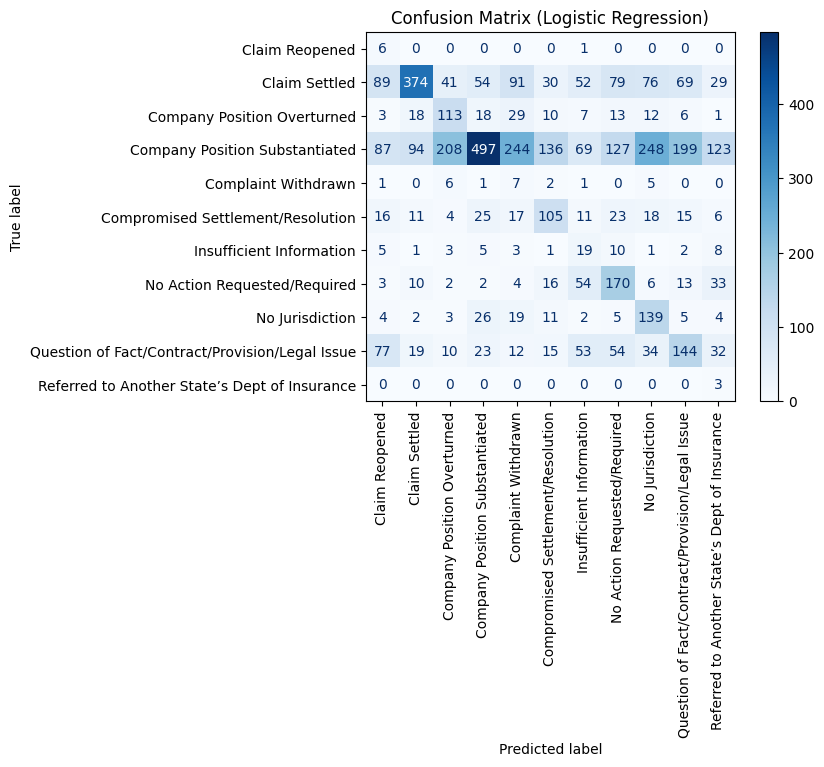

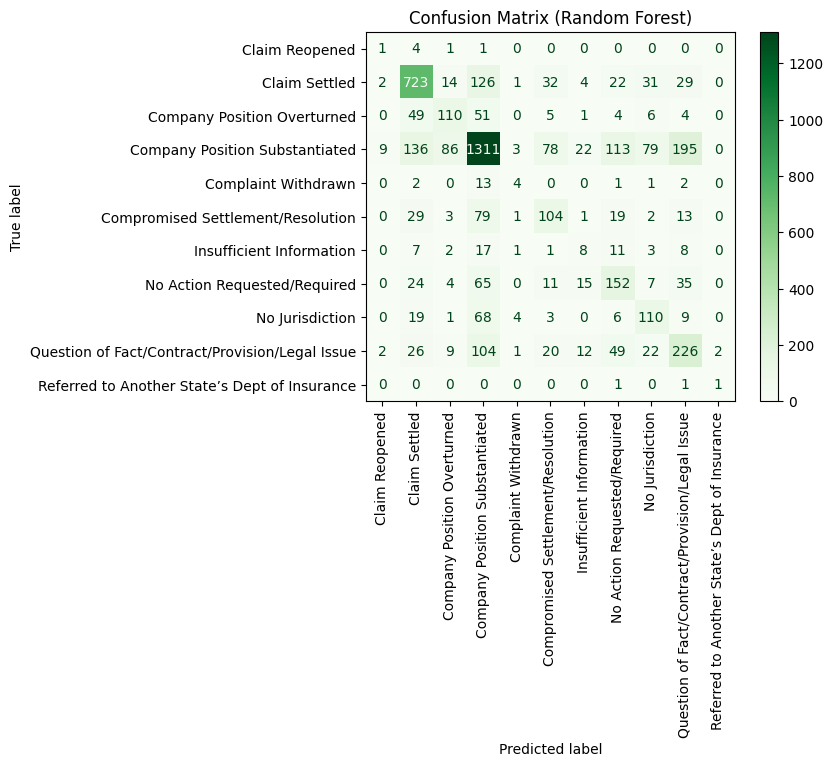

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(lr_clf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.xticks(rotation=90)
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, cmap='Greens')
plt.title("Confusion Matrix (Random Forest)")
plt.xticks(rotation=90)
plt.show()

### Neural Network

We will train a NN on the data to see how it compares to the simpler models.

NN Architecture: input layer, 2 hidden layers (Hidden Layer 1: 512 Neurons, Hidden Layer 2: 256 Neurons), output layer

In [29]:
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping


#read data and make pd dataframe
insurance_data = pd.read_csv("./Insurance_Data.csv")
insurance_data.head()
data_frame = pd.DataFrame(insurance_data)


# Removing non categorical features and status for now 
cols = [1,9,10,11]
data_frame.drop(data_frame.columns[cols], axis=1, inplace=True)

#removing null vals, want to drop the rows where disposition is missing
data_frame.dropna(inplace=True)
print(data_frame["Disposition"])

#encode y
y = data_frame["Disposition"]
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)


#encode x
X = data_frame.drop(columns=["Disposition"])
X = pd.get_dummies(X)

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, train_size=0.8, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)


model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(256, activation="relu"))  
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(y_cat.shape[1], activation="softmax"))


model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])


# Convert y_encoded back to flat labels
y_int = np.argmax(y_train, axis=1)

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_int),
    y=y_int
)

# Map to a dictionary
class_weights = dict(enumerate(weights))

early_stopping = EarlyStopping(
    monitor="val_loss",      
    patience=10,              
    min_delta=0.001,          
    restore_best_weights=True  
)

history = model.fit(
 X_train, y_train,
 validation_data=(X_val, y_val),
 batch_size=256,
 epochs=500,
 callbacks=[early_stopping],
class_weight=class_weights

)

model.summary()

0           Company Position Substantiated
1                            Claim Settled
2                            Claim Settled
3                            Claim Settled
4        Compromised Settlement/Resolution
                       ...                
38256       Company Position Substantiated
38257       Company Position Substantiated
38259                        Claim Settled
38263       Company Position Substantiated
38264                        Claim Settled
Name: Disposition, Length: 18537, dtype: object
Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1784 - loss: 2.7627 - val_accuracy: 0.3301 - val_loss: 2.0781
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3402 - loss: 1.9573 - val_accuracy: 0.5040 - val_loss: 1.6288
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4978 - loss: 1.3425 - val_accuracy: 0.5330 - val_loss: 1.3994
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6028 - loss: 0.9986 - val_acc

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     1,896,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,094,889 (23.25 MB)

 Trainable params: 2,031,629 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,063,260 (15.50 MB)

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 1.0373
1.042468786239624 0.6806904077529907


### NN Results

Accuracy: Range ~0.68 - 0.74

In [36]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Acuracy: {acc:.4f}")

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

Training Loss: 0.2834, Training Accuracy: 0.9122
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 1.0373
Test Loss: 1.0425, Test Acuracy: 0.6807
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                                                             precision    recall  f1-score   support

                                             Claim Reopened       1.00      0.67      0.80         9
                                              Claim Settled       0.73      0.69      0.71       878
                                Company Position Overturned       0.74      0.92      0.82       198
                             Company Position Substantiated       0.80      0.67      0.73      1566
                                        Complaint Withdrawn       0.46      0.72      0.57        18
                          Compromised Settlement/Resolution       0.48      0.57      0.52       188
                                   Insufficient Information       0.50      0.51      0

/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Conclusion

This experiment with Logistic Regression, Random Forest, and NN tells us the following things:

1. The dataset is imbalanced
   - This is shown in the high F-1 scores for categories with lots of samples, compared to the low F-1 score for samples with low samples. This suggests that the models are likely not predicting the disposition correctly, but rather are classifying most data points into the most common category, giving the illusion of correct predictions.
   - This is a problem that needs to be addressed when constructing more complex models, and should be taken into consiteration during the training process.
   - This also indicates that dataset would benefit from SMOTE (synthetic minority over-sampling technique), which would create more representation for smaller categories in the data.
2. There is a trade-off between:
   - Simple model, low accuracy and heavily affected by imbalanced data
   - Complex model, higher accuracy and handles imbalanced data better, but prone to overfitting (Higher, consistant F-1 Score)

Bottom Line: Our dataset was very imbalanced and hard to work with. It was very imbalanced (few dominating categories, many sparse categories), and had lots of NaN data which had to be dealt with.